In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.6
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.3.0
anndata             0.7.6
anyio               NA
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
cairo               1.20.1
certifi             2021.05.30
cffi                1.14.4
chardet             4.0.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
debugpy             1.3.0
decorator           5.0.9
defusedxml          0.7.1
dunamai             1.5.5
get_version         3.2
google              NA
h5py                3.3.0
idna                2.10
igraph              0.8.3
ipykernel           6.0.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              3.0.1
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.9.0
jupyterlab_server   2.6.0
kiwisolver  

In [4]:
save_path= '../results/log_regression/'

In [5]:
# my train data
#adata_P13 = sc.read('../../cellranger/data/adata_raw_sc_and_sn_with_unified_annotation_upd_20210914.h5ad')
adata_P13 = sc.read('../../MFIdata_anna/adata_all_donors_all_cell_states_raw_counts_in_raw_normlog_counts_in_X_for_download.h5ad')

In [6]:
# my test data
Trophoblasts = sc.read('../results/scVI/S9_scVIintegrated_Trophoblasts_latent30.h5ad')

# Highly variable genes of Trophoblasts



In [7]:
Trophoblasts_raw=Trophoblasts.raw.to_adata()

In [8]:
adata_raw=sc.read('../data/S1_preprocessed_noNormalized_adata.h5ad')

In [9]:
Trophoblasts_raw = adata_raw[adata_raw.obs.index.isin(list(Trophoblasts_raw.obs.index))]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


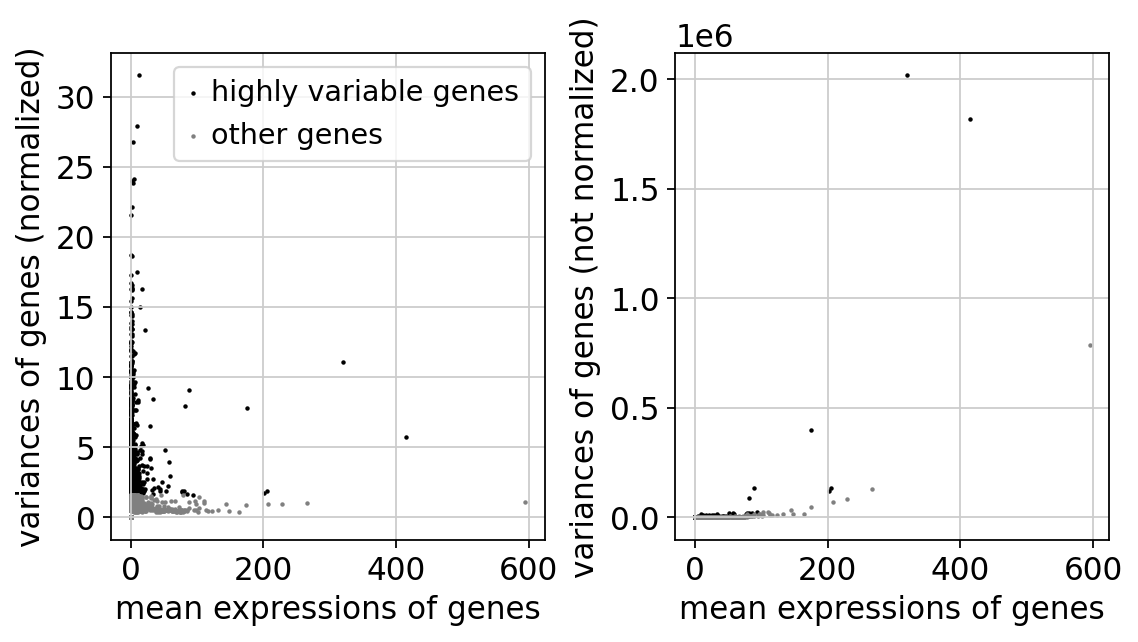

Total number of cells: 6787
Total number of genes: 3000


In [10]:
#  HVGs. Seurat 3 expects non-normalized counts
sc.pp.highly_variable_genes(Trophoblasts_raw, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(Trophoblasts_raw)

#saving the highl variable genes
highly_variable_genesTrophoblasts = Trophoblasts_raw.var["highly_variable"]
Trophoblasts_raw = Trophoblasts_raw[:, highly_variable_genesTrophoblasts]

print('Total number of cells: {:d}'.format(Trophoblasts_raw.n_obs))
print('Total number of genes: {:d}'.format(Trophoblasts_raw.n_vars))

In [14]:
Trophoblasts_raw.var.to_csv('../results/tables/highlyVariable_genesTrophoblasts.csv')

# Subsetting the trophoblasts



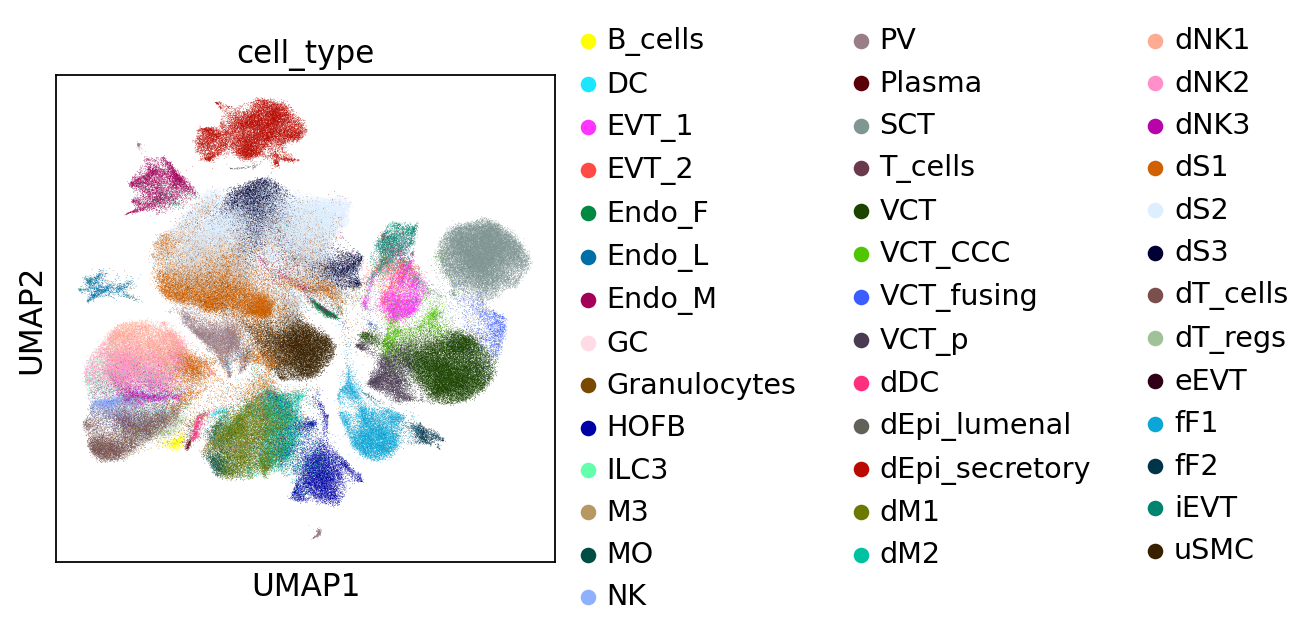

In [12]:
sc.pl.umap(adata_P13, color=['cell_type'], color_map='OrRd',wspace=0.3)

In [18]:
temp_cells = adata_P13[adata_P13.obs['cell_type'] == 'SCT']

temp_cells2= adata_P13[adata_P13.obs['cell_type'] == 'VCT_CCC']
temp_cells3= adata_P13[adata_P13.obs['cell_type'] == 'VCT_fusing']
temp_cells4= adata_P13[adata_P13.obs['cell_type'] == 'VCT_p']
temp_cells5= adata_P13[adata_P13.obs['cell_type'] == 'VCT']

temp_cells6= adata_P13[adata_P13.obs['cell_type'] == 'EVT_1']
temp_cells7= adata_P13[adata_P13.obs['cell_type'] == 'EVT_2']
temp_cells8= adata_P13[adata_P13.obs['cell_type'] == 'iEVT']
temp_cells9= adata_P13[adata_P13.obs['cell_type'] == 'eEVT']

In [20]:
adata_P13_sub = temp_cells.concatenate(temp_cells2, temp_cells3, temp_cells4, temp_cells5, temp_cells6,
                                      temp_cells7, temp_cells8, temp_cells9, index_unique=None)

... storing 'sample' as categorical
... storing 'tissue' as categorical
... storing 'dev_age' as categorical
... storing 'donor' as categorical
... storing 'dataset' as categorical
... storing 'celltype_predictions' as categorical
... storing 'phase' as categorical
... storing 'origin_M_F' as categorical
... storing 'cell_type' as categorical


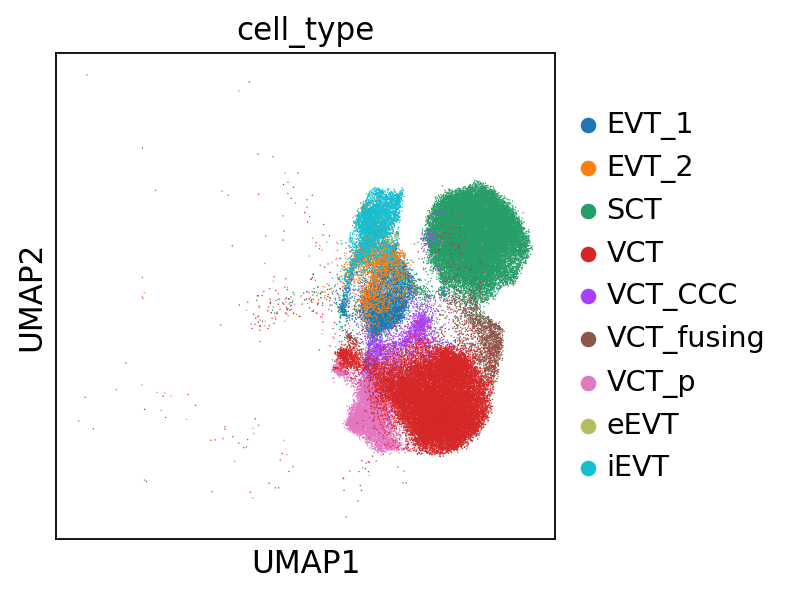

In [21]:
sc.pl.umap(adata_P13_sub, color=['cell_type'], color_map='OrRd',wspace=0.3)

# LOGISTIC REGRESSION

### Subsetting both datasets' copies to common genes only

Can be either overlap of all genes that passed QC or HVG overlap

In [22]:
adata_P13_sub.var

,gene_ids-10,feature_types-10,genome-10,gene_ids-11,feature_types-11,genome-11,gene_ids-12,feature_types-12,genome-12,gene_ids-13,...,n_cells-56-8,n_cells-57-8,n_cells-58-8,n_cells-59-8,n_cells-6-8,n_cells-60-8,n_cells-61-8,n_cells-7-8,n_cells-8-8,n_cells-9-8
A1BG,ENSG00000121410,Gene Expression,GRCh38,ENSG00000121410,Gene Expression,GRCh38,ENSG00000121410,Gene Expression,GRCh38,ENSG00000121410,...,135.0,99.0,332.0,188.0,34.0,159.0,160.0,140.0,185.0,608.0
A1BG-AS1,ENSG00000268895,Gene Expression,GRCh38,ENSG00000268895,Gene Expression,GRCh38,ENSG00000268895,Gene Expression,GRCh38,ENSG00000268895,...,182.0,109.0,154.0,231.0,3.0,223.0,217.0,14.0,20.0,91.0
A1CF,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,5.0,18.0,42.0,5.0,NaN,12.0,15.0,NaN,NaN,NaN
A2M,ENSG00000175899,Gene Expression,GRCh38,ENSG00000175899,Gene Expression,GRCh38,ENSG00000175899,Gene Expression,GRCh38,ENSG00000175899,...,1983.0,1099.0,3020.0,2482.0,3.0,1429.0,1333.0,NaN,5.0,2117.0
A2M-AS1,ENSG00000245105,Gene Expression,GRCh38,ENSG00000245105,Gene Expression,GRCh38,ENSG00000245105,Gene Expression,GRCh38,ENSG00000245105,...,55.0,39.0,16.0,68.0,13.0,36.0,25.0,59.0,61.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,ENSG00000070476,Gene Expression,GRCh38,ENSG00000070476,Gene Expression,GRCh38,ENSG00000070476,Gene Expression,GRCh38,ENSG00000070476,...,1736.0,1831.0,2430.0,1760.0,8.0,2541.0,2641.0,26.0,32.0,122.0
ZYG11A,nan,nan,nan,ENSG00000203995,Gene Expression,GRCh38,nan,nan,nan,nan,...,131.0,54.0,69.0,92.0,NaN,216.0,226.0,NaN,NaN,NaN
ZYG11B,ENSG00000162378,Gene Expression,GRCh38,ENSG00000162378,Gene Expression,GRCh38,ENSG00000162378,Gene Expression,GRCh38,ENSG00000162378,...,1660.0,1310.0,1934.0,1544.0,13.0,2735.0,2810.0,22.0,47.0,183.0
ZYX,ENSG00000159840,Gene Expression,GRCh38,ENSG00000159840,Gene Expression,GRCh38,ENSG00000159840,Gene Expression,GRCh38,ENSG00000159840,...,1369.0,1016.0,1871.0,1623.0,65.0,1795.0,1690.0,265.0,319.0,2351.0


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


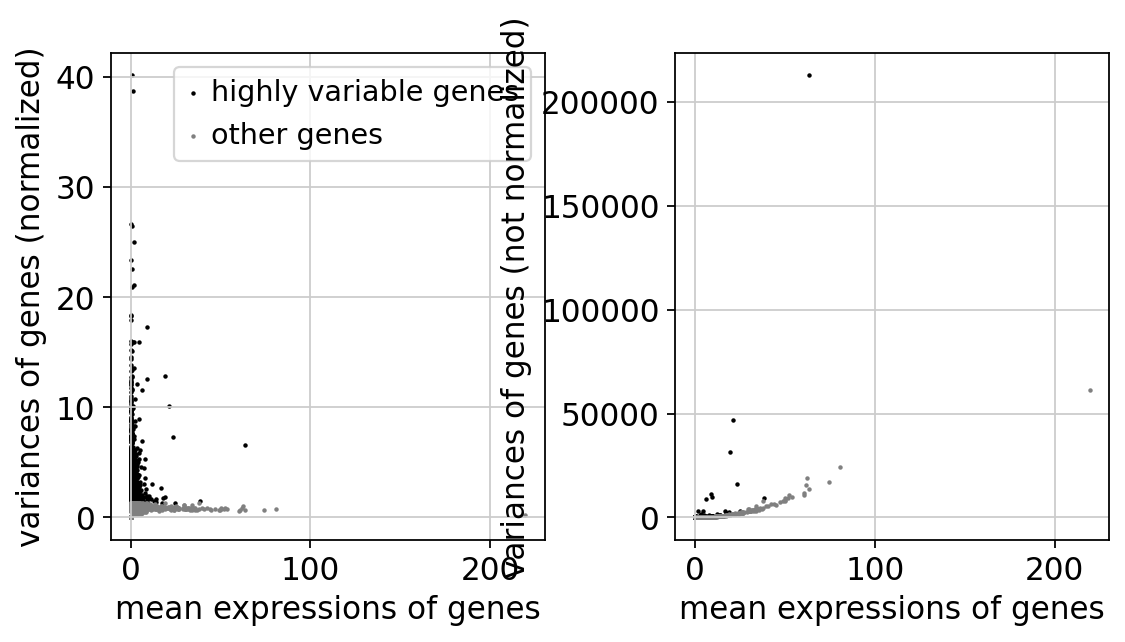

Total number of cells: 75023
Total number of genes: 3000


In [23]:
sc.pp.highly_variable_genes(adata_P13_sub, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(adata_P13_sub)

#saving the highl variable genes
highly_variable_genes = adata_P13_sub.var["highly_variable"]
adata_P13_downsampled = adata_P13_sub[:, highly_variable_genes]

print('Total number of cells: {:d}'.format(adata_P13_downsampled.n_obs))
print('Total number of genes: {:d}'.format(adata_P13_downsampled.n_vars))

In [24]:
#Reading the HVG annotation done in S1
highly_variable_genesTrophoblasts


A1BG        False
A1BG-AS1    False
A1CF        False
A2M          True
A2M-AS1     False
            ...  
ZXDC        False
ZYG11A      False
ZYG11B      False
ZYX         False
ZZEF1       False
Name: highly_variable, Length: 31625, dtype: bool

In [25]:
#creating a new column for the highly variable genes
Trophoblasts.var['highly_variable']=False

#adding the True values to those genes considered as HVG
for gene in list(highly_variable_genesTrophoblasts.index):
    Trophoblasts.var.at[gene, 'highly_variable']=True



In [27]:
#saving the highl variable genes
#highly_variable_genes = Trophoblasts.var["highly_variable"]
adata_hvg = Trophoblasts[:, highly_variable_genesTrophoblasts]

print('Total number of cells: {:d}'.format(adata_hvg.n_obs))
print('Total number of genes: {:d}'.format(adata_hvg.n_vars))

Total number of cells: 6787
Total number of genes: 3000


In [28]:
# here using only HVG overlap

# normlog, scaled and HVG subsetted 
adata_train = adata_P13_downsampled.copy()
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.scale(adata_train, max_value=10)

# normlog, scaled and HVG subsetted 
adata_test = adata_hvg.copy()
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.scale(adata_test, max_value=10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [29]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between annotated train and our joint data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

1634 genes are shared between annotated train and our joint data 
 3000 genes in training data 
 3000 genes in test joint data 



In [30]:
#Subseting the datasets
adata_train_copy = adata_train[:,common_genes]
adata_train_copy.var_names

Index(['A2M', 'AADACL2-AS1', 'AADACL3', 'AADAT', 'ABCA1', 'ABCA12', 'ABCA7',
       'ABCB1', 'ABCG1', 'ABHD5',
       ...
       'ZNF114', 'ZNF117', 'ZNF208', 'ZNF365', 'ZNF367', 'ZNF521', 'ZNF703',
       'ZNF704', 'ZNF804A', 'ZNRF3'],
      dtype='object', length=1634)

In [31]:
#Subseting the datasets
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A2M', 'AADACL2-AS1', 'AADACL3', 'AADAT', 'ABCA1', 'ABCA12', 'ABCA7',
       'ABCB1', 'ABCG1', 'ABHD5',
       ...
       'ZNF114', 'ZNF117', 'ZNF208', 'ZNF365', 'ZNF367', 'ZNF521', 'ZNF703',
       'ZNF704', 'ZNF804A', 'ZNRF3'],
      dtype='object', length=1634)

In [32]:
# checking gene correspondence - important!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [33]:
adata_train_copy.obs

,n_genes,sample,technology,tissue,dev_age,donor,dataset,number_of_individuals_multiplexed,batch,percent_mito,n_counts,celltype_predictions,probabilities,S_score,G2M_score,phase,origin_M_F,coarse_annot,cell_type
barcode_sample,,,,,,,,,,,,,,,,,,,
GCGCGATAGATATGGT-1_FCA7167219,506.0,FCA7167219,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,1,0,0.005571,1077.0,16_EVT,0.523403,-0.020422,-0.031178,G1,F,Trophoblast,SCT
GCGCGATAGATATGGT-1_FCA7167221,521.0,FCA7167221,10X_3'_scRNA-seq,decidua_immune,11_PCW,7,Vento_Nature,1,0,0.005803,1034.0,20_SCT,0.336042,-0.033961,-0.074408,G1,M,Trophoblast,SCT
CGTGAGCTCACATACG-1_FCA7167222,419.0,FCA7167222,10X_3'_scRNA-seq,decidua_non_immune,11_PCW,7,Vento_Nature,1,0,0.020864,671.0,16_EVT,0.272002,-0.062360,-0.087539,G1,F,Trophoblast,SCT
GCGCGATAGATATGGT-1_FCA7167222,684.0,FCA7167222,10X_3'_scRNA-seq,decidua_non_immune,11_PCW,7,Vento_Nature,1,0,0.002985,1675.0,20_SCT,0.961275,-0.029119,-0.042861,G1,F,Trophoblast,SCT
GGATGTTCACAACTGT-1_FCA7167222,3599.0,FCA7167222,10X_3'_scRNA-seq,decidua_non_immune,11_PCW,7,Vento_Nature,1,0,0.000640,21866.0,3_dS2,1.000000,-0.026680,-0.079815,G1,F,Trophoblast,SCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCAGGGTACGT-1_Pla_HDBR10701666,2980.0,Pla_HDBR10701666,10X_3'_snRNA-seq,decidua,6_PCW,Hrv43,HDBR_new,1,8,0.024646,6857.0,16_EVT,1.000000,-0.133498,-0.141930,G1,F,Trophoblast,eEVT
CCTTAGTGTTCCATTA-1_Pla_Camb10714919,945.0,Pla_Camb10714919,10X_multiome,decidua_placenta_myometrium,8-9_PCW,P13,Ashley_collection_sn,1,8,0.011018,1906.0,16_EVT,0.369721,0.088642,-0.069846,S,F,Trophoblast,eEVT
CGCTCCATCGGTTTCC-1_Pla_Camb10714919,6607.0,Pla_Camb10714919,10X_multiome,decidua_placenta_myometrium,8-9_PCW,P13,Ashley_collection_sn,1,8,0.007774,36146.0,3_dS2,1.000000,-0.044030,-0.136537,G1,F,Trophoblast,eEVT


In [34]:
np.unique(adata_train_copy.obs['cell_type'],return_counts=True)

(array(['EVT_1', 'EVT_2', 'SCT', 'VCT', 'VCT_CCC', 'VCT_fusing', 'VCT_p',
        'eEVT', 'iEVT'], dtype=object),
 array([ 5289,  2358, 28177, 23472,  3373,  1971,  6679,    28,  3676]))

## Training a logistic regression model on previously annotated 10X data from Roser+Suryawanshi

In [35]:
adata_train_copy.obs['cell_type'].head()

barcode_sample
GCGCGATAGATATGGT-1_FCA7167219    SCT
GCGCGATAGATATGGT-1_FCA7167221    SCT
CGTGAGCTCACATACG-1_FCA7167222    SCT
GCGCGATAGATATGGT-1_FCA7167222    SCT
GGATGTTCACAACTGT-1_FCA7167222    SCT
Name: cell_type, dtype: category
Categories (9, object): ['EVT_1', 'EVT_2', 'SCT', 'VCT', ..., 'VCT_fusing', 'VCT_p', 'eEVT', 'iEVT']

In [36]:
celltypes_train = adata_train_copy.obs['cell_type']

In [37]:
adata_train_copy.X.shape

(75023, 1634)

# The following cell actually trains the model and may require quite a bit of time if you are using a big training dataset

In [38]:
#17:50
%time
# training a logistic regression model on scRNA-seq data
# takes about 5hrs for HVGs intersection
logisticRegr_sc = LogisticRegression(max_iter = 5000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr_sc.fit(adata_train_copy.X, celltypes_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


LogisticRegression(C=0.2, max_iter=5000, n_jobs=-1, random_state=0)

In [39]:
# Saving model

#pkl_filename = "./logreg_from_P13_downsampled_no_soupy_genes_coarse_troph_to_all_troph_organoids_premrna_HVGs.pkl"
pkl_filename = "../results/log_regression/logreg_trophoblastOnly_to_explant_premrna_HVGs_20220502.pkl"



with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr_sc, file)

In [5]:
# Load model (scRNA-seq) from file

# which one?
pkl_filename = "../results/log_regression/logreg_trophoblastOnly_to_explant_premrna_HVGs_20220502.pkl"

with open(pkl_filename, 'rb') as file:  
    logisticRegr_sc = pickle.load(file)

In [40]:
logisticRegr_sc

LogisticRegression(C=0.2, max_iter=5000, n_jobs=-1, random_state=0)

In [41]:
%%time
predictions = logisticRegr_sc.predict(adata_test_copy.X)
adata_test_copy.obs['celltype_predictions'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 279 ms, sys: 88 ms, total: 367 ms
Wall time: 373 ms


In [42]:
%%time
# probabilities
probabilities = logisticRegr_sc.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['celltype_predictions']):
    probs_adata.append(probabilities[i,logisticRegr_sc.classes_==clus][0])



CPU times: user 90.1 ms, sys: 20 ms, total: 110 ms
Wall time: 114 ms


In [43]:
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

True

In [44]:
adata_test_copy.obs['celltype_predictions']

Pla_HDBR10917730_AAACCCAGTAGCTCGC           SCT
Pla_HDBR10917730_AAAGGTATCAAGGTGG           VCT
Pla_HDBR10917730_AACAACCCACAATGTC           SCT
Pla_HDBR10917730_AACACACAGCTCATAC    VCT_fusing
Pla_HDBR10917730_AATGCCATCCGCTGTT    VCT_fusing
                                        ...    
Pla_HDBR11345033_TTGTTGTTCCCATAGA           SCT
Pla_HDBR11345033_TTGTTTGAGTCTGCAT           SCT
Pla_HDBR11345033_TTTACTGGTATACGGG         EVT_2
Pla_HDBR11345033_TTTCATGCATATCTCT       VCT_CCC
Pla_HDBR11345033_TTTGGTTAGCCTAGGA           SCT
Name: celltype_predictions, Length: 6787, dtype: object

In [45]:
# now you can return to your object transferring celltype predictions and their probabilities from training

# my test object
Trophoblasts.obs['celltype_predictions'] = adata_test_copy.obs.loc[Trophoblasts.obs_names,'celltype_predictions']
Trophoblasts.obs['probabilities'] = probs_adata

In [46]:
# you may want to save results at this point
Trophoblasts.obs.loc[:,['celltype_predictions','probabilities']].to_csv('../results/log_regression/logreg_trophoblastOnly_to_explant_premrna_HVGs_predictions_20220502.csv')

